# `Практикум по программированию на языке Python`

## `Задание 1.5. Классификация изображений`.

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__5 марта__</span>.

Мягкий дедлайн: <span style="color:red">__12 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __3 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

#### `Москва, 2024`

In [171]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd

random_seed = 0
torch.manual_seed(random_seed)

device = torch.device('cuda:0' if torch.cuda.is_available(
) else 'mps:0' if torch.backends.mps.is_available() else "cpu")
print(device)

mps:0


## `Задание 1. Загрузка данных (0.5 балла)`

В этой домашке работа с данными будем максимально облегчённой. Мы скачаем MNIST с помощью [стандартных средств](https://pytorch.org/vision/0.8/datasets.html#mnist) торча. Посмотреть список других доступных датасетов можно [здесь](https://pytorch.org/vision/0.8/datasets.html).

In [2]:
def load_mnist(train, transform=None):
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )

Посмотрим на примеры изображений, чтобы понимать, с чем мы имеем дело

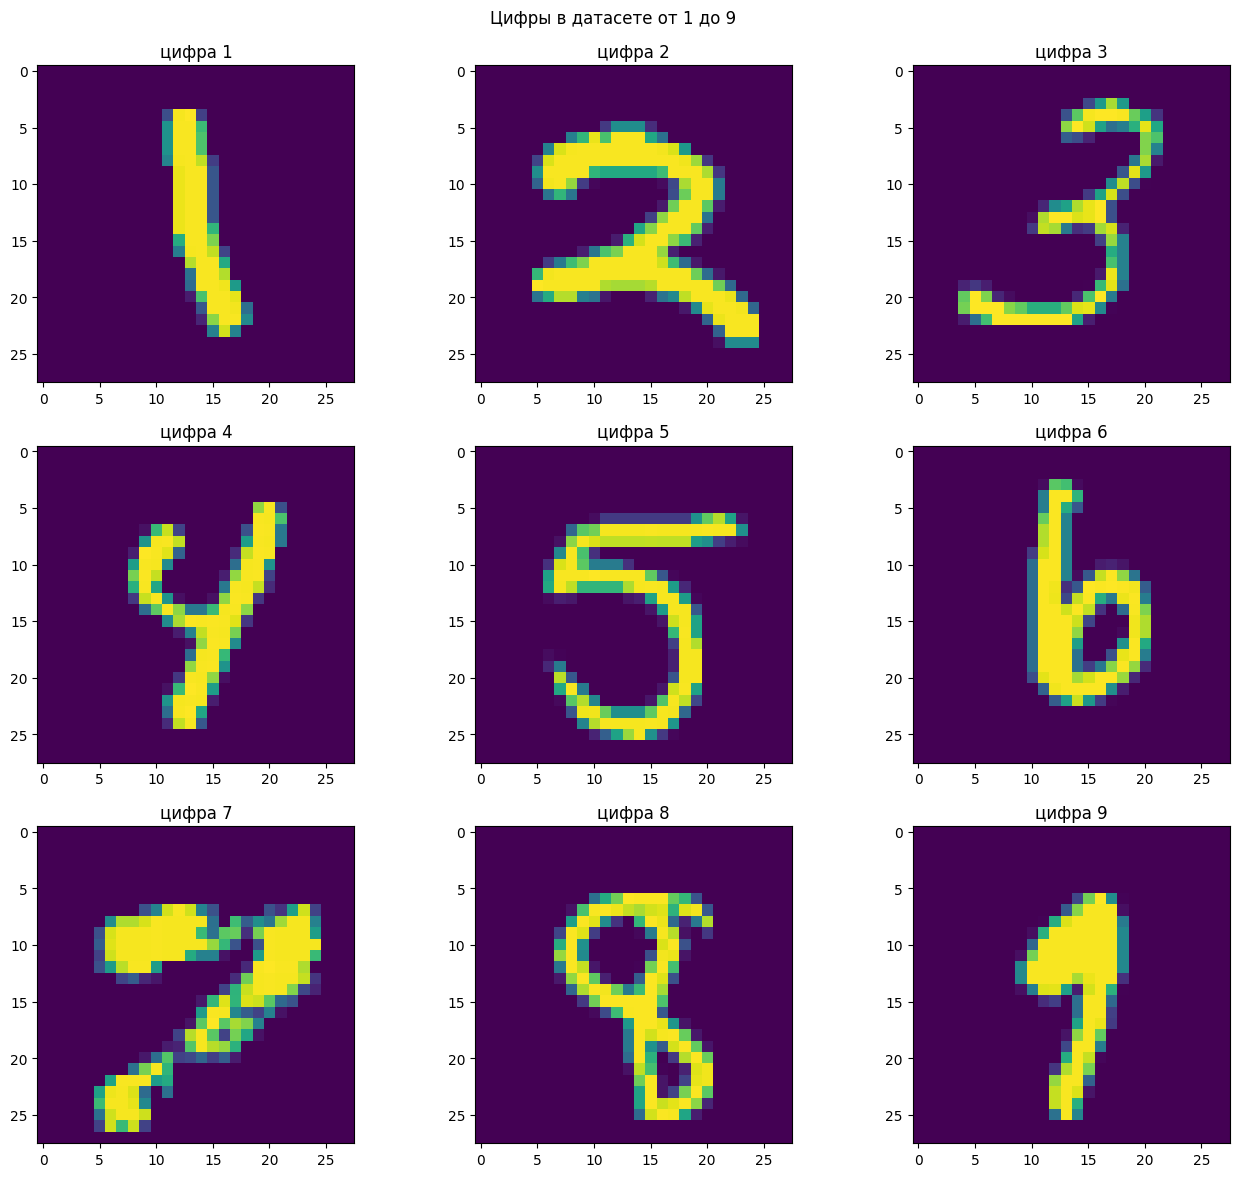

In [45]:
fig, axis = plt.subplots(3, 3)
fig.set_figwidth(16)
fig.set_figheight(14)

title = fig.suptitle('Цифры в датасете от 1 до 9')
title.set_position((0.5, 0.92))
for i, dig in enumerate(load_mnist(True).targets.unique()[1:]):
    dig_indx = torch.where(load_mnist(True).targets == dig)[0]
    perm = torch.randperm(dig_indx.size(0))
    idx = perm[:1]
    rand_img = load_mnist(True).data[dig_indx[idx]]

    axis[i // 3][i % 3].imshow(rand_img.reshape((28, 28)))
    axis[i // 3][i % 3].set_title(f'цифра {i + 1}')

Пиксели изображений принимают значения [0,1]. Скачайте датасет и посчитайте выборочное среднее и выборочное стандартное отклонение для значения пикселя. Т.е. должно получиться число `mean` для среднего, и число `std` для стандартного отклонения.

*Подсказка.* Подумайте, на какой части датасета нужно считать эти статистики (обучение или валидация), чтобы предотвратить утечку данных.

*Подсказка.* У торч датасета реализован метод `__getitem__`, т.е. его можно индексировать `dataset[i]`.

In [3]:
# your code is here
mnist_train = load_mnist(True)

# getting mean and standard deviation masks for each pixel in 28 x 28 pictures
# we obtain that statistics from the only train data to prevent leakage
mean = torch.mean(mnist_train.data.float())
std = torch.std(mnist_train.data.float())

Полученные значения можно применить для нормализации изображений, когда будем подавать их в нейросеть.

In [4]:
norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_mnist = load_mnist(True, norm_transform)
val_mnist = load_mnist(False, norm_transform)

Во время обучения данные подаются в нейросеть батчами.

Обычно batch_size выбирается так, чтобы во время обучения получалась меньше дисперсия градиента (ну вы уже знакомы с sgd), также часто batch_size выбирается максимально возможным по ресурсам.

Для этой задачи нам хватит batch_size = 64 во время обучения.

*Ответьте на вопрос:* Почему в большинстве задач для валидации и тестирования можно выбирать batch_size больше? 

__Ответ:__ мы можем позволить себе брать размер батча больше на валидации и тесте так как на данном этапе мы не обучаем модель и не высчитываем градиенты. Соответсвенно нам не требуется хранить дополнительные данные в памяти (тем более видео памяти, что и так слишком мало), а на место, где раньше выделялось место под производные, мы можем записывать данные для батчей

In [5]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True
)

val_mnist_loader = DataLoader(
    dataset=val_mnist,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False
)

In [134]:
len(train_mnist_loader.dataset)

60000

In [126]:
images, labels = next(iter(train_mnist_loader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

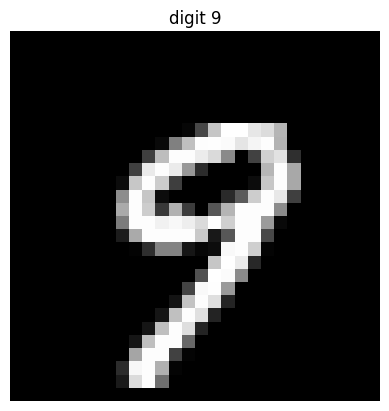

In [128]:
i = 5
plt.title(f'digit {labels[i]}')
plt.imshow(images[i, 0], cmap='gray')
plt.axis('off')
plt.show()

## `Задание 2. Цикл обучения (1.5 балла)`

Ниже предоставлен базовый вариант цикла обучения, представленный тремя функциями: `train_epoch`, `val_epoch`, `train_val`.

In [9]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
):
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""

    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(
            device)   # send data to device
        optimizer.zero_grad()   # zero out grads, collected from previous batch
        logits = network(images)  # forward pass
        loss = criterion(logits, labels, reduction='mean')
        loss.backward()
        optimizer.step()

In [154]:
@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion,
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0

    network.eval()  # switch network submodules to test mode
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        logits = network(images)
        val_loss += criterion(logits, labels, reduction='sum').item()
        pred = torch.argmax(logits, dim=1)
        correct += torch.sum(pred == labels).item()

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

In [155]:
def train_val(
    network,
    n_epochs,
    criterion,
    optimizer,
    train_loader,
    val_loader,
):
    """full cycle of neural network training"""

    print(f'---------epoch=0---------')
    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        print(f'---------{epoch=}---------')
        train_epoch(network, train_loader, criterion, optimizer)
        val_epoch(network, val_loader, criterion)

Для проверки, что все работает, обучите бейзлайн -- однослойную [полносвязную](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) сеть на [кросс-энтропийный лосс](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). 


*Заметьте*, что на вход этому лоссу нужно подавать сырой выход нейросети, а не результат применения софтмакса.

In [16]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.dense = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [157]:
model = LogReg()
model.to(device)
train_val(model, 5, nn.functional.cross_entropy, optim.Adam(
    model.parameters()), train_mnist_loader, val_mnist_loader)

---------epoch=0---------
Test set: Avg. loss: 2.3403 Accuracy: 980/10000 (10%)
---------epoch=1---------
Test set: Avg. loss: 2.3120 Accuracy: 1135/10000 (11%)
---------epoch=2---------
Test set: Avg. loss: 2.3020 Accuracy: 982/10000 (10%)
---------epoch=3---------
Test set: Avg. loss: 2.2900 Accuracy: 1135/10000 (11%)
---------epoch=4---------
Test set: Avg. loss: 2.2732 Accuracy: 1979/10000 (20%)
---------epoch=5---------
Test set: Avg. loss: 2.2900 Accuracy: 2206/10000 (22%)


## `Задание 3. Логирование (3 балл)`

Скопируйте и перепишите функции `train_epoch`, `val_epoch`, `train_val` таким образом, чтобы
- во время обучения раз в `logging_interval` шагов оптимизации выводились лосс и аккураси на одном батче (пример ниже, но не обязательно делать идентично)
- происходило сохранение весов лучшей (по аккураси на валидации) модели и состояния оптимизатора ([в помощь](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended))
- в конце обучения выводился и сохранялся график-саммари (пример ниже, но не обязательно делать идентично)

*Ответьте на вопрос:* Что хранится в состоянии оптимизатора? Зачем нужно его сохранять? Приведите хотя бы один пример оптимизатора, для которого есть смысл сохранять состояние.

__Ответ:__ В состоянии оптимизатора мы хотим видеть все веса модели, ведь в таком случае, зная архитектуру сети, мы сможем с точностью восстановить ее. Сохранять состояние модели в процессе обучения может быть в особенности важно, когда оптимизатор работает не стабильно и модель от итерации к итерации сильно меняет свое конечное качество (понять это мы можем, например, по качеству модели на отложенных валидационных данных). Соответсвенно, наблюдать за качеством модели нужно исключительно на данных, не используемых в обучении, а в случае ухудшения качества работы сети, мы в любой момент можем вернуться к оптимальному состоянию. 

Оптимизаторы, что нуждаются в таком подходе больше всего: явным образом SGD или тот же SGD+momentum

In [7]:
def train_epoch(
    model: nn.Module,
    train_loader,
    criterion,
    optimizer,
    curr_epoch=None,
    logging_interval=None
):
    losses = []

    model.train()
    for i, (batch, labels) in enumerate(train_loader):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, labels, reduction='mean')
        loss.backward()
        optimizer.step()

        if logging_interval is not None and i % logging_interval == 0:
            losses.append(loss.item())
            print(f'Train Epoch: {
                  curr_epoch + 1} [{batch.shape[0] * i}/{len(train_loader.dataset)}] Loss: {loss:.4f}')

    return losses

In [9]:
@torch.no_grad()
def val_epoch(
    model: nn.Module,
    val_loader,
    criterion
):
    model.eval()

    losses = []
    accurate = 0

    for batch, labels in val_loader:
        batch, labels = batch.to(device), labels.to(device)
        out = model(batch)
        losses.append(criterion(out, labels, reduction='sum'))
        preds = torch.argmax(out, dim=1)
        accurate += torch.sum(preds == labels).item()

    accuracy = accurate / len(val_loader.dataset)
    avg_loss = sum(losses) / len(val_loader.dataset)

    print(f'\nValidation: average loss: {avg_loss:.4f} Accuracy: {
          accurate}/{len(val_loader.dataset)} ({round(accuracy * 100)}%)')

    return avg_loss.item(), accuracy

In [64]:
def train_val(
    model: nn.Module,
    n_epoches: int,
    criterion,
    optimizer: optim.Optimizer,
    train_loader,
    val_loader,
    logging_interval: int | None = None,
    dump_path: str | None = None,
    show_plots: bool = False
):

    loss, acc = val_epoch(model, val_loader, criterion)

    if dump_path is not None:
        if not os.path.exists(dump_path):
            os.mkdir(dump_path)
        curr_best_acc = acc
        torch.save(model.state_dict(), os.path.join(dump_path, 'model.pt'))
        torch.save(optimizer.state_dict(), os.path.join(dump_path, 'optim.pt'))

    losses_train = []
    losses_valid = [loss]
    accuracies = [acc]

    for epoch in range(n_epoches):
        losses = train_epoch(model, train_loader, criterion,
                             optimizer, epoch, logging_interval)
        loss, acc = val_epoch(model, val_loader, criterion)

        losses_train += losses
        losses_valid.append(loss)
        accuracies.append(acc)

        if dump_path is not None and acc > curr_best_acc:
            curr_best_acc = acc
            torch.save(model.state_dict(), os.path.join(dump_path, 'model.pt'))
            torch.save(optimizer.state_dict(),
                       os.path.join(dump_path, 'optim.pt'))

    if show_plots:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(
            'Метрики функций loss и accuracy на валидации за время обучения')

        axes[0].set_title('loss')
        axes[0].grid()
        axes[1].set_title('accuracy')
        axes[1].grid()
        axes[0].set_ylabel('loss')
        axes[1].set_ylabel('accuracy')
        axes[0].set_xlabel('epoch')
        axes[1].set_xlabel('epoch')

        # print(len(losses), len(losses_train), len(losses_train) // n_epoches)
        axes[0].plot(np.linspace(0, len(losses_valid) - 1, len(losses_valid)), losses_valid, label='Valid loss',
                     c='darkgreen')
        axes[0].scatter(np.linspace(0, len(losses_valid) - 1,
                        len(losses_valid)), losses_valid, c='darkgreen')
        axes[0].plot(np.linspace(0, len(losses_valid) - 1, len(losses_train)),
                     losses_train, label='Train loss', c='brown')
        axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
        axes[0].legend()

        axes[1].plot(range(0, len(accuracies)), accuracies,
                     label='Train acc.', c='dodgerblue')
        axes[1].scatter(range(0, len(accuracies)), accuracies, c='dodgerblue')
        axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

In [13]:
train_mnist_loader.batch_size

64

In [11]:
def load_model(dir_path: str):
    model_state = torch.load(os.path.join(dir_path, 'model.pt'))
    optimizator_state = torch.load(os.path.join(dir_path, 'optim.pt'))

    return model_state, optimizator_state


Validation: average loss: 2.3213 Accuracy: 1135/10000 (11%)
Train Epoch: 1 [0/60000] Loss: 2.3512
Train Epoch: 1 [9600/60000] Loss: 2.3552
Train Epoch: 1 [19200/60000] Loss: 2.4102
Train Epoch: 1 [28800/60000] Loss: 2.3660
Train Epoch: 1 [38400/60000] Loss: 2.3048
Train Epoch: 1 [48000/60000] Loss: 2.3426
Train Epoch: 1 [57600/60000] Loss: 2.3298

Validation: average loss: 2.3236 Accuracy: 974/10000 (10%)
Train Epoch: 2 [0/60000] Loss: 2.3660
Train Epoch: 2 [9600/60000] Loss: 2.3127
Train Epoch: 2 [19200/60000] Loss: 2.3133
Train Epoch: 2 [28800/60000] Loss: 2.2670
Train Epoch: 2 [38400/60000] Loss: 2.2998
Train Epoch: 2 [48000/60000] Loss: 2.2784
Train Epoch: 2 [57600/60000] Loss: 2.3231

Validation: average loss: 2.3022 Accuracy: 1135/10000 (11%)
Train Epoch: 3 [0/60000] Loss: 2.2879
Train Epoch: 3 [9600/60000] Loss: 2.2850
Train Epoch: 3 [19200/60000] Loss: 2.2833
Train Epoch: 3 [28800/60000] Loss: 2.2750
Train Epoch: 3 [38400/60000] Loss: 2.2969
Train Epoch: 3 [48000/60000] Loss: 

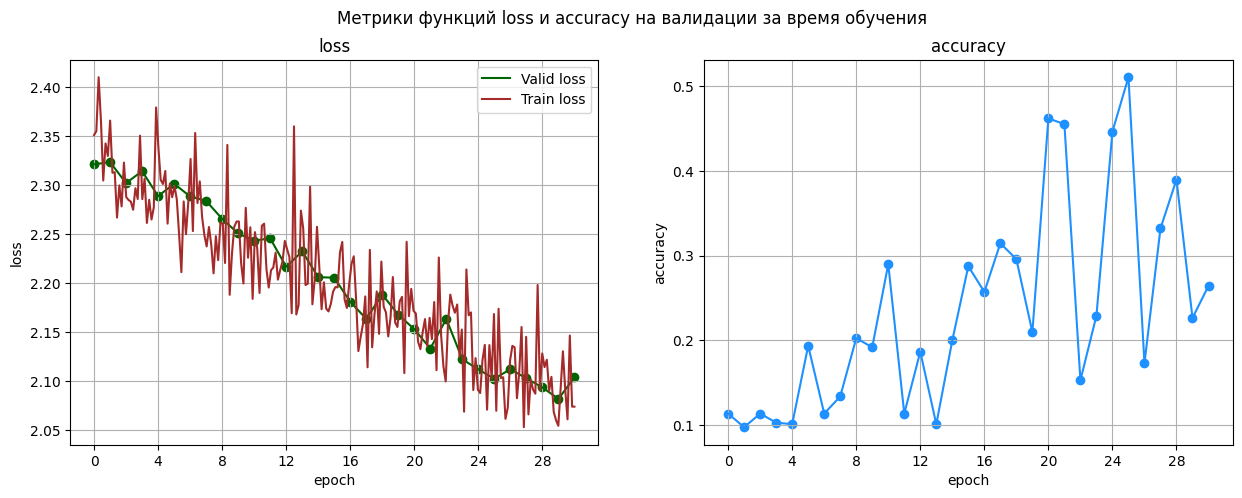

In [67]:
model = LogReg()
model.to(device)
train_val(model=model,
          n_epoches=30,
          criterion=nn.functional.cross_entropy,
          optimizer=optim.Adam(model.parameters()),
          train_loader=train_mnist_loader,
          val_loader=val_mnist_loader,
          logging_interval=150,
          dump_path='./dump_model_logregr/',
          show_plots=True)

Загрузите лучшие веса модели и подсчитайте аккураси на валидации, чтобы подтвердить что веса сохранились корректно.

In [69]:
model_state, optimizator_state = load_model('./dump_model_logregr/')

model = LogReg()
model.to(device)
model.load_state_dict(model_state)
_ = val_epoch(model, val_mnist_loader, nn.functional.cross_entropy)


Validation: average loss: 2.1026 Accuracy: 5105/10000 (51%)


Действительно, сохранение состояния прошло правильно.

Загрузите сохранённое состояние оптимизатора и сделайте две эпохи обучения, чтобы подтвердить, что состояния оптимизатора были сохранены корректно.

In [70]:
model_state, optimizator_state = load_model('./dump_model_logregr/')

model = LogReg()
model.to(device)
model.load_state_dict(model_state)

optimizator = optim.Adam(model.parameters())
optimizator.load_state_dict(optimizator_state)

train_val(model=model,
          n_epoches=2,
          criterion=nn.functional.cross_entropy,
          optimizer=optimizator,
          train_loader=train_mnist_loader,
          val_loader=val_mnist_loader,
          logging_interval=250,
          dump_path='./dump_model_logregr/')


Validation: average loss: 2.1026 Accuracy: 5105/10000 (51%)
Train Epoch: 1 [0/60000] Loss: 2.1071
Train Epoch: 1 [16000/60000] Loss: 2.1184
Train Epoch: 1 [32000/60000] Loss: 2.1135
Train Epoch: 1 [48000/60000] Loss: 2.1504

Validation: average loss: 2.1159 Accuracy: 3222/10000 (32%)
Train Epoch: 2 [0/60000] Loss: 2.1508
Train Epoch: 2 [16000/60000] Loss: 2.1568
Train Epoch: 2 [32000/60000] Loss: 2.1067
Train Epoch: 2 [48000/60000] Loss: 2.0873

Validation: average loss: 2.1265 Accuracy: 1821/10000 (18%)


## `Задание 4. Логирование с помощью tensorboard (1 балл)`

На самом деле это дурной тон логировать обучение нейросети так, как это сделали вы выше. Дело в том, что весь функционал уже реализован в [`tensorboard`](https://pytorch.org/docs/stable/tensorboard.html), а вы написали велосипед.

In [71]:
! pip3 install tensorboard
from torch.utils.tensorboard import SummaryWriter

Если у вас есть доступ к терминалу и браузеру, то удобнее всего ввести команду
```bash
tensorboard --logdir .
```
и открыть UI в выделенном локалхосте. 

Если вы работаете в гугл колабе, то можете запустить UI как виджет в Jupyter:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir .

Как только вы начнете логировать в объект типа `SummaryWriter`, в UI начнут строиться кривые обучения.

Скопируйте и перепишите функции обучения таким образом, чтобы логирование происходило в `tensorboard`.

*Замечание.* Вам пригодится метод `add_scalar`, чтобы сохранять лосс и аккураси, и метод `add_hparams`, чтобы сохранить важные гиперпараметры (например, кодовое имя архитектуры сети) и финальное достигнутое качество.

In [164]:
def train_epoch(
    model: nn.Module,
    train_loader,
    criterion,
    optimizer,
    logging_interval=None,
    logger: SummaryWriter = None,
    epoch: int = None
):

    model.train()
    for i, (batch, labels) in enumerate(train_loader):
        batch, labels = batch.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, labels, reduction='mean')
        loss.backward()
        optimizer.step()

        if logging_interval is not None and i % logging_interval == 0:
            logger.add_scalar('Loss/train', loss,
                              epoch * (len(train_loader.dataset) // len(batch)) // logging_interval + i // logging_interval + epoch)


@torch.no_grad()
def val_epoch(
    model: nn.Module,
    val_loader,
    criterion,
    logger: SummaryWriter = None,
    epoch: int = None
):
    model.eval()

    losses = []
    accurate = 0

    for i, (batch, labels) in enumerate(val_loader):
        batch, labels = batch.to(device), labels.to(device)
        out = model(batch)
        losses.append(criterion(out, labels, reduction='sum'))
        preds = torch.argmax(out, dim=1)
        accurate += torch.sum(preds == labels).item()
        if logger is not None:
            logger.add_scalar('Loss/validate', sum(losses) / len(losses),
                              epoch * (len(val_loader.dataset) // len(batch)) // 1 + i // 1 + epoch)

    if logger is not None:
        logger.add_scalar('Accuracy/validate', accurate /
                          len(val_loader.dataset), epoch)

    accuracy = accurate / len(val_loader.dataset)
    return accuracy


def train_val(
    model: nn.Module,
    n_epoches: int,
    criterion,
    optimizer: optim.Optimizer,
    train_loader,
    val_loader,
    logging_interval: int | None = None,
    logger: SummaryWriter | None = None,
    dump_path: str | None = None,
):

    acc = val_epoch(model, val_loader, criterion, logger=logger, epoch=0)

    if dump_path is not None:
        if not os.path.exists(dump_path):
            os.mkdir(dump_path)
        curr_best_acc = acc
        torch.save(model.state_dict(), os.path.join(dump_path, 'model.pt'))
        torch.save(optimizer.state_dict(), os.path.join(dump_path, 'optim.pt'))

    for epoch in range(n_epoches):
        train_epoch(model, train_loader, criterion, optimizer,
                    logging_interval, logger=logger, epoch=epoch)
        acc = val_epoch(model, val_loader, criterion,
                        logger=logger, epoch=epoch+1)

        if dump_path is not None and acc > curr_best_acc:
            curr_best_acc = acc
            torch.save(model.state_dict(), os.path.join(dump_path, 'model.pt'))
            torch.save(optimizer.state_dict(),
                       os.path.join(dump_path, 'optim.pt'))

In [140]:
logger = SummaryWriter()

model = LogReg()
model.to(device)
train_val(model=model,
          n_epoches=30,
          criterion=nn.functional.cross_entropy,
          optimizer=optim.Adam(model.parameters()),
          train_loader=train_mnist_loader,
          val_loader=val_mnist_loader,
          logging_interval=150,
          dump_path='./dump_model_logregr/',
          logger=logger)

Попробуем получить хорошее качество на MNIST

In [162]:
class MNISTBest(nn.Module):
    def __init__(self):
        super().__init__()

        # input 28 * 28
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=7)
        self.activation1 = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm2d(num_features=3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=7)
        self.activation2 = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(8 * 8, 32)
        self.activation3 = nn.ReLU()
        self.batchNorm2 = nn.BatchNorm1d(32)
        self.dense2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.batchNorm1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.activation3(x)
        x = self.batchNorm2(x)
        x = self.dense2(x)

        return x

In [ ]:
logger = SummaryWriter()
model = MNISTBest()
model.to(device)
train_val(model=model,
          n_epoches=100,
          criterion=nn.functional.cross_entropy,
          optimizer=optim.Adam(model.parameters()),
          train_loader=train_mnist_loader,
          val_loader=val_mnist_loader,
          logging_interval=150,
          dump_path='./dump_model_MNISTBest/',
          logger=logger)

In [167]:
model_state, optimizator_state = load_model('./dump_model_logregr/')

model = MNISTBest()
model.to(device)
model.load_state_dict(model_state)
best_mnist_accuracy = val_epoch(
    model, val_mnist_loader, nn.functional.cross_entropy)
print('Best accuracy on MNIST test:', best_mnist_accuracy)

Best accuracy on MNIST test: 0.9662


<Axes: title={'center': 'Accuracy over validation'}, xlabel='Step', ylabel='Value'>

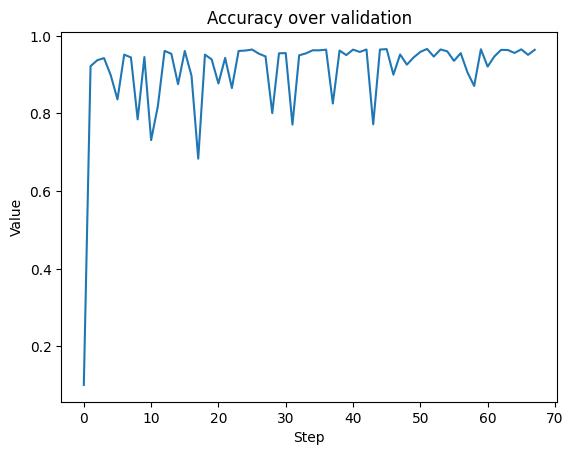

In [175]:
acc_line = pd.read_csv('./MNIST_best.csv')
plt.title('Accuracy over validation')
sns.lineplot(acc_line, x='Step', y='Value')

## `Задание 5. Побейте бейзлайн (2+2 балла)`

На датасете [`CIFAR-10`](https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.CIFAR10) обучите модель, которая выдает аккураси `>=0.7` (2 балла) и аккураси `>=0.8` (ещё 2 балла).
- Можете использовать любые модули `pytorch`, любые оптимизаторы и шедулеры, можете использовать аугментации ([например](https://pytorch.org/vision/stable/transforms.html))
- Для отслеживания экспериментов используйте логирование с `tensorboard`, не забывайте давать осмысленные имена эспериментам и логировать нужные гиперпараметры, сохранять веса сети и состояние оптимизатора.

In [208]:
def load_CIFAR(train, transform=None):
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.CIFAR10(
        root='./data/CIFAR',
        train=train,
        transform=transform,
        download=True
    )

In [169]:
cifar_train = load_CIFAR(True)

100.0%


Extracting ./data/CIFAR/cifar-10-python.tar.gz to ./data/CIFAR


In [221]:
cifar_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/CIFAR
    Split: Train
    StandardTransform
Transform: ToTensor()

AttributeError: 'CIFAR10' object has no attribute 'target_to_idx'

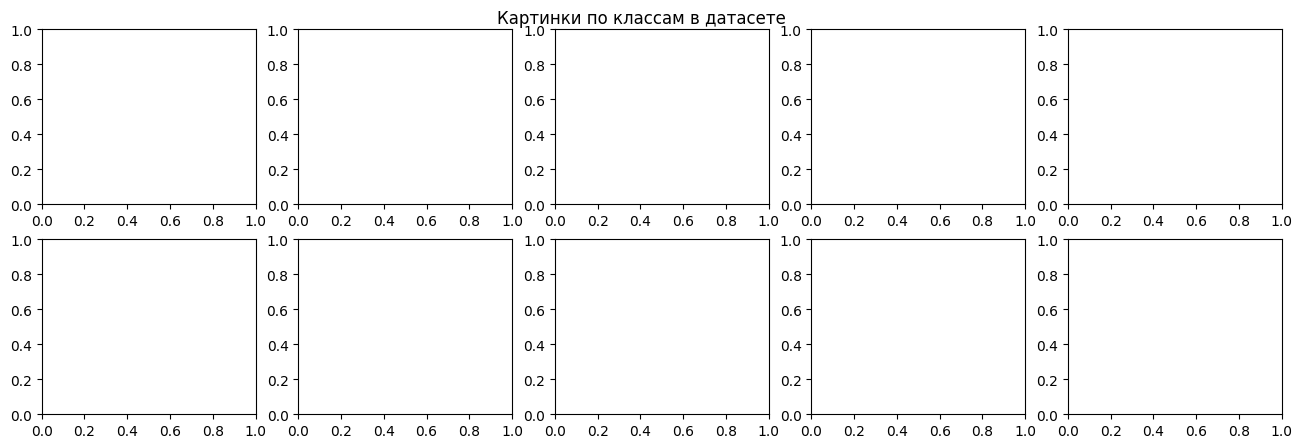

In [220]:
fig, axis = plt.subplots(2, 5)
fig.set_figwidth(16)
fig.set_figheight(5)

title = fig.suptitle('Картинки по классам в датасете')
title.set_position((0.5, 0.92))
parser = {ind: key for key, ind in cifar_train.target_to_idx}

for i, dig in enumerate(np.unique(cifar_train.targets)):
    dig_indx = np.where(cifar_train.targets == dig)[0]
    idx = np.random.choice(dig_indx)
    rand_img = cifar_train.data[idx]

    axis[i // 5][i % 5].imshow(rand_img.reshape((32, 32, -1)))
    axis[i // 5][i % 5].set_title(f'цифра {i + 1}')

In [ ]:
from torch.utils.data import DataLoader

batch_size_train = 64
batch_size_test = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=batch_size_train,
    shuffle=True,
    drop_last=True
)

val_mnist_loader = DataLoader(
    dataset=val_mnist,
    batch_size=batch_size_test,
    shuffle=False,
    drop_last=False
)

## `Бонус. Побейте бейзлайн (3 балла)`

На датасете `CIFAR-10` обучите модель, которая выдает аккураси `>=0.9`.

In [ ]:
self.conv_small_tower = nn.Sequential(
    nn.Conv1d(in_channels=0, out_channels=3, kernel_sisize=9),
    nn.ReLU(),
    nn.BatchNorm1d(),
    nn.MaxPool1d(2),
    nn.Conv1d(in_channels=3, out_channels=8, kernel_sisize=11),
    nn.ReLU(),
    nn.BatchNorm1d(),
    nn.MaxPool1d(2),
    nn.Conv1d(in_channels=8, out_channels=3, kernel_sisize=3),
    nn.ReLU(),
    nn.BatchNorm1d(),
    nn.MaxPool1d(2),
)

In [ ]:
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5)
nn.ReLU()
nn.BatchNorm2d(num_features=16)
nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5)
nn.ReLU()
nn.BatchNorm2d(num_features=32)
nn.MaxPool2d(2)
nn.Conv2d(in_channels=32, out_channels=16, kernel_size=5)
nn.ReLU()
nn.BatchNorm2d(num_features=3)
nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5)
nn.ReLU()
nn.BatchNorm2d(num_features=8)
nn.MaxPool2d(2)
nn.Flatten()

In [ ]:
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9),
nn.ReLU(),
nn.BatchNorm2d(num_features=16),
nn.Conv2d(in_channels=16, out_channels=32, kernel_size=7),
nn.ReLU(),
nn.BatchNorm2d(num_features=32),
nn.MaxPool2d(3),
nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3),
nn.ReLU(),
nn.BatchNorm2d(num_features=16),
nn.MaxPool2d(2),
nn.Flatten(),

In [ ]:
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=13)
nn.ReLU()
nn.BatchNorm2d(num_features=16)
nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9)
nn.ReLU()
nn.BatchNorm2d(num_features=32)
nn.MaxPool2d(2)
nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3)
nn.ReLU()
nn.BatchNorm2d(num_features=16)
nn.MaxPool2d(2)
nn.Flatten()

In [ ]:
nn.Linear(128, 64),
nn.Dropout(),
nn.ReLU(),
nn.Linear(64, 32),
nn.ReLU(),
nn.Linear(32, 10),